<a href="https://colab.research.google.com/github/sujeongzoe/KDT/blob/main/%5BDiabetes%5DMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install XGBoost
!pip install optuna
!pip install shap

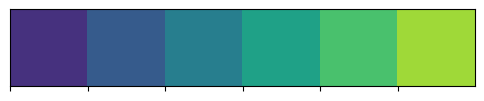

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc
from functools import partial
from sklearn.preprocessing import RobustScaler as RS
from sklearn.preprocessing import StandardScaler as SS
from tensorflow.keras.callbacks import EarlyStopping

pal = sns.color_palette("viridis")
sns.set_palette(pal)
sns.palplot(pal)

In [ ]:
data = pd.read_csv("/content/diabetes.csv")

cols = data.columns
for col in cols:
    mean = data[col].mean()
    std = data[col].std()
    threshold = mean + 3 * std
    n_outlier = np.sum(data[col] > threshold)
    data.drop(data[data[col] > threshold].index[:], inplace=True)


data.loc[data.BMI == 0,"BMI"] = data.BMI.median()
data.loc[data.SkinThickness == 0,"SkinThickness"] = data.SkinThickness.median()

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

scaler = RS()
# scaler = SS()
X = pd.DataFrame(scaler.fit_transform(X), columns=data.columns[:8])
X = X.drop(columns = ['BloodPressure'])


# X[X.BMI == 0] = X.BMI.median()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
data.loc[data.BMI == 0,"BMI"] = data.BMI.median()

In [ ]:
data[data.SkinThickness == 0] = data.SkinThickness.median()

In [ ]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,727.000000,727.000000,727.000000,727.000000,727.000000,727.0,727.000000,727.000000,727.000000
mean,3.819807,119.217331,68.925722,19.980743,68.649243,32.0,0.447455,32.858322,0.338377
std,3.289811,31.317086,19.438892,15.605225,89.144538,0.0,0.277929,11.264807,0.473483
min,0.000000,0.000000,0.000000,0.000000,0.000000,32.0,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,32.0,0.242000,24.000000,0.000000
50%,3.000000,115.000000,72.000000,22.000000,16.000000,32.0,0.364000,29.000000,0.000000
75%,6.000000,138.000000,80.000000,32.000000,120.000000,32.0,0.600000,40.000000,1.000000
max,13.000000,199.000000,122.000000,60.000000,415.000000,32.0,1.400000,68.000000,1.000000


In [ ]:
def optimize1(trial, x,y):
    params = {
        "kernel":trial.suggest_categorical("kernel",['linear','rbf','sigmoid','poly']),
        'random_state':42,
        'gamma':trial.suggest_float('gamma',1e-2,10.0),
        'max_iter':trial.suggest_int('max_iter',10,100),
        }
    model = SVC(**params)
    kf = StratifiedKFold(n_splits=5)
    accuracies = []
    precision_scores = []
    recall_scores = []
    F1_scores = []
    for idx in kf.split(X=x,y=y):
        train_idx,test_idx = idx[0],idx[1]
        xtrain = x.iloc[train_idx]
        ytrain = y[train_idx]
        xtest = x.iloc[test_idx]
        ytest = y[test_idx]
        model.fit(xtrain,ytrain)
        preds =  model.predict(xtest)
        fold_acc = accuracy_score(ytest,preds)
        precision = precision_score(ytest,preds)
        recall = recall_score(ytest,preds)
        F1_score = f1_score(ytest,preds)
        accuracies.append(fold_acc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        F1_scores.append(F1_score)
    return np.mean(accuracies), np.mean(F1_scores), np.mean(precision_scores), np.mean(recall_scores)

In [ ]:
def optimize2(trial, x,y):
    params = {
        'random_state':42,
        'max_iter':trial.suggest_int('max_iter',10,100),
        }
    model = LogisticRegression(**params)
    kf = StratifiedKFold(n_splits=5)
    accuracies = []
    precision_scores = []
    recall_scores = []
    F1_scores = []
    for idx in kf.split(X=x,y=y):
        train_idx,test_idx = idx[0],idx[1]
        xtrain = x.iloc[train_idx]
        ytrain = y[train_idx]
        xtest = x.iloc[test_idx]
        ytest = y[test_idx]
        model.fit(xtrain,ytrain)
        preds =  model.predict(xtest)
        fold_acc = accuracy_score(ytest,preds)
        precision = precision_score(ytest,preds)
        recall = recall_score(ytest,preds)
        F1_score = f1_score(ytest,preds)
        accuracies.append(fold_acc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        F1_scores.append(F1_score)
    return np.mean(accuracies), np.mean(F1_scores), np.mean(precision_scores), np.mean(recall_scores)

In [ ]:
def optimize3(trial, x,y):
    #parameter set is declare within function
    #suggest_uniform : 범위 내의 균일 분포 값을 선택.
    #suggest_discrete_uniform : 이산 균등 분포를 값으로 선택.
    #suggest_loguniform : 범위 내의 로그 함수 선상의 값을 선택.

    params = {
        'random_state':42,
        'n_jobs':-1,
        'min_child_weight':trial.suggest_int('min_child_weight',5,100),
        'reg_lambda':trial.suggest_float('reg_lambda',0.1,10.0),
        'reg_alpha':trial.suggest_float('reg_alpha',0.1,10.0),
        'gamma':trial.suggest_float('gamma',1e-2,10.0),
        'n_estimators':trial.suggest_int('n_estimators',10,100),
        'max_depth':trial.suggest_int('max_depth',3,16),
        'learning_rate':trial.suggest_float('learning_rate',1e-5,1e-2),
        }
    model = XGBClassifier(**params)
    kf = StratifiedKFold(n_splits=5)
    accuracies = []
    precision_scores = []
    recall_scores = []
    F1_scores = []
    for idx in kf.split(X=x,y=y):
        train_idx,test_idx = idx[0],idx[1]
        xtrain = x.iloc[train_idx]
        ytrain = y[train_idx]
        xtest = x.iloc[test_idx]
        ytest = y[test_idx]
        model.fit(xtrain,ytrain)
        preds =  model.predict(xtest)
        fold_acc = accuracy_score(ytest,preds)
        precision = precision_score(ytest,preds)
        recall = recall_score(ytest,preds)
        F1_score = f1_score(ytest,preds)
        accuracies.append(fold_acc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        F1_scores.append(F1_score)
    return np.mean(accuracies), np.mean(F1_scores), np.mean(precision_scores), np.mean(recall_scores)

# SVC

In [ ]:
optimization_fuction = partial(optimize1,x = X, y = y)
study1 = optuna.create_study(directions=['maximize','maximize','maximize','maximize'])
#Printing the best hyperparemeter set
study1.optimize(optimization_fuction, n_trials=200)

# Logistic Regression

In [ ]:
optimization_fuction = partial(optimize2,x = X, y = y)

study2 = optuna.create_study(directions=['maximize','maximize','maximize','maximize'])

#Printing the best hyperparemeter set

study2.optimize(optimization_fuction, n_trials=200)

# XGB Classifier

In [ ]:
optimization_fuction = partial(optimize3,x = X, y = y)

study3 = optuna.create_study(directions=['maximize','maximize','maximize','maximize'])

#Printing the best hyperparemeter set

study3.optimize(optimization_fuction, n_trials=200)

In [ ]:
score_names = ['Accuracy','F1_score','Precision','Recall']
max_f1, max_pre, max_rec = 0, 0, 0
best_mdl = []
for best_model in study1.best_trials:
  for idx, name in enumerate(score_names):
    if idx == 1 and max_f1 < best_model.values[idx]: best_mdl.append(best_model)
    elif idx == 2 and max_pre < best_model.values[idx]: best_mdl.append(best_model)
    elif idx == 3 and max_rec < best_model.values[idx]: best_mdl.append(best_model)
    print(f' {name} score : {round(best_model.values[idx], 3)} ',end='')
  print(f'\nBest_params = {best_model.params}')

In [ ]:
score_names = ['Accuracy','F1_score','Precision','Recall']
max_f1, max_pre, max_rec = 0, 0, 0
best_mdl = []
for best_model in study2.best_trials:
  for idx, name in enumerate(score_names):
    if idx == 1 and max_f1 < best_model.values[idx]: best_mdl.append(best_model)
    elif idx == 2 and max_pre < best_model.values[idx]: best_mdl.append(best_model)
    elif idx == 3 and max_rec < best_model.values[idx]: best_mdl.append(best_model)
    print(f' {name} score : {round(best_model.values[idx], 3)} ',end='')
  print(f'\nBest_params = {best_model.params}')

In [ ]:
score_names = ['Accuracy','F1_score','Precision','Recall']
max_f1, max_pre, max_rec = 0, 0, 0
best_mdl = []
for best_model in study3.best_trials:
  for idx, name in enumerate(score_names):
    if idx == 1 and max_f1 < best_model.values[idx]: best_mdl.append(best_model)
    elif idx == 2 and max_pre < best_model.values[idx]: best_mdl.append(best_model)
    elif idx == 3 and max_rec < best_model.values[idx]: best_mdl.append(best_model)
    print(f' {name} score : {round(best_model.values[idx], 3)} ',end='')
  print(f'\nBest_params = {best_model.params}')

In [ ]:
from tensorflow.keras.layers import Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(7,1)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_236 (Dense)           (None, 7, 256)            512       
                                                                 
 batch_normalization_165 (Ba  (None, 7, 256)           1024      
 tchNormalization)                                               
                                                                 
 dropout_168 (Dropout)       (None, 7, 256)            0         
                                                                 
 flatten_57 (Flatten)        (None, 1792)              0         
                                                                 
 dense_237 (Dense)           (None, 128)               229504    
                                                                 
 batch_normalization_166 (Ba  (None, 128)              512       
 tchNormalization)                                   

In [ ]:
callback = EarlyStopping(restore_best_weights=True, patience=100, monitor='val_binary_accuracy', verbose = 1,mode='max')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
hist = model.fit(X_train, y_train,epochs=1000, validation_data=(X_test, y_test), callbacks = [callback])

Epoch 1/1000
19/19 [==============================] - 3s 27ms/step - loss: 0.7362 - binary_accuracy: 0.6695 - val_loss: 0.6247 - val_binary_accuracy: 0.8219
Epoch 2/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.5846 - binary_accuracy: 0.7470 - val_loss: 0.6003 - val_binary_accuracy: 0.7123
Epoch 3/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.5274 - binary_accuracy: 0.7522 - val_loss: 0.6036 - val_binary_accuracy: 0.6712
Epoch 4/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.5368 - binary_accuracy: 0.7522 - val_loss: 0.5870 - val_binary_accuracy: 0.6712
Epoch 5/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.4951 - binary_accuracy: 0.7556 - val_loss: 0.5834 - val_binary_accuracy: 0.6712
Epoch 6/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.4946 - binary_accuracy: 0.7831 - val_loss: 0.5806 - val_binary_accuracy: 0.6712
Epoch 7/1000
19/19 [==============================] - 0s 1

In [ ]:
Ímlp_preds = model.predict(X_test)
mlp_preds_thres = mlp_preds // 0.5

5/5 [==============================] - 0s 5ms/step


<Axes: >

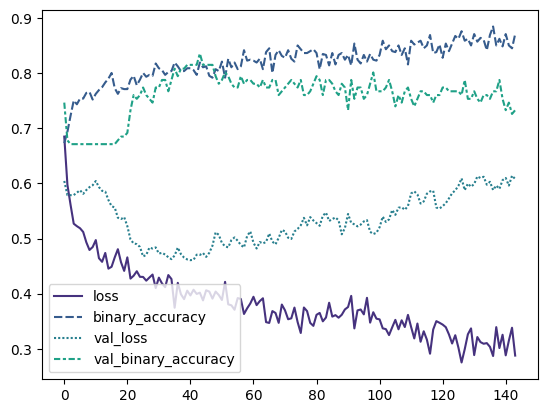

In [ ]:
his_dict = hist.history
sns.lineplot(his_dict)

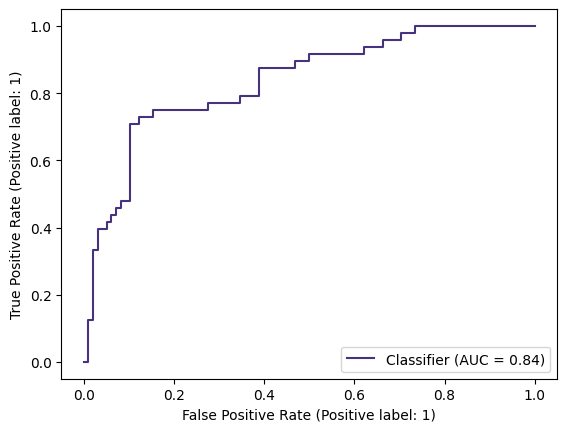

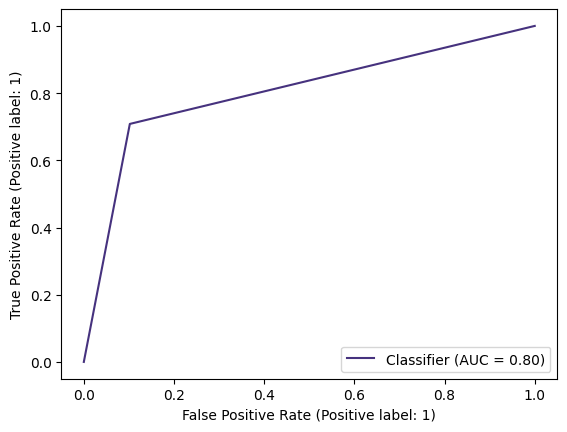

In [ ]:
RocCurveDisplay.from_predictions(y_test, mlp_preds)
plt.show()
RocCurveDisplay.from_predictions(y_test, mlp_preds_thres)
plt.show()

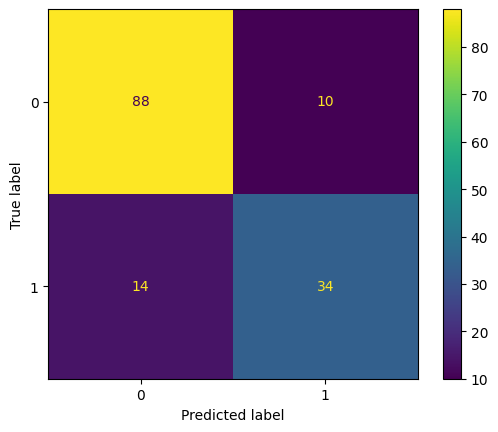


recall : 0.7083333333333334	precision : 0.7727272727272727	f1_score : 0.7391304347826088
0.8356164383561644


In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, mlp_preds_thres, cmap="viridis")
plt.show()
recall = recall_score(y_test, mlp_preds_thres)
precision = precision_score(y_test, mlp_preds_thres)
f1 = f1_score(y_test, mlp_preds_thres)
acc = accuracy_score(y_test, mlp_preds_thres)
print(f'\nrecall : {recall}\tprecision : {precision}\tf1_score : {f1}')
print(acc)

In [ ]:
Í